In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [237]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import math as mt
import datetime as dt
from sklearn.cluster import KMeans
import random as ran
from sklearn.metrics.pairwise import euclidean_distances as euc
from functools import reduce

# 한글출력
matplotlib.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

from src import crs
from IPython.display import clear_output

In [4]:
# 1. load_excel

# data/apt_all.xlsx
# data/apt_1.xlsx
# data/apt_3.xlsx
# data/apt_4.xlsx
# data/apt_std_nugin_1_3.xlsx

data_path = "data/apt_1.xlsx"
xlsx = pd.read_excel(data_path, header=None,
                     skiprows=2, engine="openpyxl")

In [5]:
# 2. data preprocessing
p, m = crs.utils.data_preprocessing(xlsx)

m.set_index("month", inplace=True)
m.head()

/Users/formegusto/Desktop/idoformegusto/development/research/what-is-public-fee/src/crs/utils/data_preprocessing.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  datas_df[household_name] = household_df[col][3:].to_list()
/Users/formegusto/Desktop/idoformegusto/development/research/what-is-public-fee/src/crs/utils/data_preprocessing.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  month_usage_df[name] = [


,아파트1-101-1002,아파트1-101-104,아파트1-101-1102,아파트1-101-1202,아파트1-101-1302,아파트1-101-1401,아파트1-101-1403,아파트1-101-1502,아파트1-101-1504,아파트1-101-1602,...,아파트1-104-303,아파트1-104-404,아파트1-104-408,아파트1-104-503,아파트1-104-507,아파트1-104-606,아파트1-104-705,아파트1-104-708,아파트1-104-902,아파트1-104-905
month,,,,,,,,,,,,,,,,,,,,,
1,253,689,183,239,455,343,380,219,389,350,...,10,111,39,151,181,180,290,184,176,148
2,251,481,177,218,397,297,339,197,348,288,...,77,107,30,114,151,151,263,177,158,127
3,255,424,203,222,378,303,349,202,357,368,...,77,120,28,116,163,157,281,182,171,127
4,252,355,180,230,368,278,298,188,346,365,...,76,64,58,109,151,148,257,175,140,121
5,230,357,258,203,414,270,418,156,320,265,...,150,63,75,137,115,13,84,149,36,117


In [444]:
_month = 1

month_df = pd.DataFrame(m.loc[_month])
month_df.reset_index(inplace=True)

month_df.columns = ['name', 'usage (kWh)']

PUBLIC_PERCENTAGE = 10
households_kWh = month_df['usage (kWh)'].sum()
APT = round((households_kWh * 100) / (100 - PUBLIC_PERCENTAGE))
public_kWh = APT - households_kWh

calc = crs.models.ManagementOffice(
        month=_month,
        households=month_df,
        APT=APT,
        contract="단일계약"
    )
apt = calc.apart

print("APT : {}kWh (평균 사용량: {}kWh)".format(format(APT, ","), apt.kwh))
print("세대부 : {} ({}%)kWh (평균 사용량: {}kWh)".format(format(households_kWh, ","), 
                                                 100 - PUBLIC_PERCENTAGE,
                                                 int(month_df['usage (kWh)'].mean())
                                                ))
print("공용부 : {} ({}%)kWh".format(format(public_kWh, ","), PUBLIC_PERCENTAGE))
month_df.head()

APT : 34,560kWh (평균 사용량: 320kWh)
세대부 : 31,104 (90%)kWh (평균 사용량: 288kWh)
공용부 : 3,456 (10%)kWh


,name,usage (kWh)
0,아파트1-101-1002,253
1,아파트1-101-104,689
2,아파트1-101-1102,183
3,아파트1-101-1202,239
4,아파트1-101-1302,455


In [445]:
apt_pd = pd.DataFrame(columns=['기본요금', '전력량요금', '환경 기후금', '연료비 조정액', 'VAT', '전력산업기반기금', '기본요금 + 전력량요금'])


apt_pd = apt_pd.append(
    pd.Series({
        "기본요금" : apt.basic,
        "전력량요금" : apt.elec_rate,
        "환경 기후금" : apt.env,
        "연료비 조정액" : apt.fuel * -1,
        'VAT': round(calc.elec_bill * 0.1 / len(month_df)),
        '전력산업기반기금': round(mt.floor(calc.elec_bill * 0.037 * 0.1) * 10 / len(month_df)),
        '기본요금 + 전력량요금': apt.basic + apt.elec_rate
    }, name="가구 수 곱 적용 전"))
apt_pd = apt_pd.append(
    pd.Series({
        "기본요금" : apt.basic * len(month_df),
        "전력량요금" : apt.elec_rate * len(month_df),
        "환경 기후금" : apt.env * len(month_df),
        "연료비 조정액" : apt.fuel * len(month_df) * -1,
        'VAT': round(calc.elec_bill * 0.1),
        '전력산업기반기금': round(mt.floor(calc.elec_bill * 0.037 * 0.1) * 10),
        '기본요금 + 전력량요금': apt.basic * len(month_df) + apt.elec_rate * len(month_df)
    }, name="가구 수 곱 적용 후"))

apt_pd

,기본요금,전력량요금,환경 기후금,연료비 조정액,VAT,전력산업기반기금,기본요금 + 전력량요금
가구 수 곱 적용 전,1260,31736,1696,-960,3373,1248,32996
가구 수 곱 적용 후,136080,3427488,183168,-103680,364306,134790,3563568


In [446]:
households = calc.households

households_pd = pd.DataFrame(columns=['기본요금', '전력량요금', '환경 기후금', '연료비 조정액', 'VAT', '전력산업기반기금', '기본요금 + 전력량요금'])

for household in households:
    households_pd = households_pd.append(
        pd.Series({
            "기본요금" : household.basic,
            "전력량요금" : household.elec_rate - household.guarantee,
            "환경 기후금" : household.env,
            "연료비 조정액" : household.fuel * -1,
            'VAT': int(household.vat), 
            '전력산업기반기금': int(household.fund),
            '기본요금 + 전력량요금': household.basic + household.elec_rate
        }, name=household.name))


households_pd.head()

,기본요금,전력량요금,환경 기후금,연료비 조정액,VAT,전력산업기반기금,기본요금 + 전력량요금
아파트1-101-1002,1260,22201,1340,-759,2404,880,23461
아파트1-101-104,6060,103983,3651,-2067,11163,4130,110043
아파트1-101-1102,730,10913,969,-549,1206,440,14143
아파트1-101-1202,1260,20209,1266,-717,2202,810,21469
아파트1-101-1302,6060,54703,2411,-1365,6181,2280,60763


In [484]:
analysis_pd = pd.concat([apt_pd.loc['가구 수 곱 적용 후'],households_pd.sum(), apt_pd.loc['가구 수 곱 적용 후'] - households_pd.sum()], axis=1).T
analysis_pd.index = ['APT', '세대부', '공용부']

analysis_pd.loc['세대부 / APT percentage'] = ((analysis_pd.loc['세대부'] / analysis_pd.loc['APT']) * 100).astype(np.float64).round().astype("int")
analysis_pd.loc['공용부 / APT percentage'] = ((analysis_pd.loc['공용부'] / analysis_pd.loc['APT']) * 100).astype(np.float64).round().astype("int")
analysis_pd

,기본요금,전력량요금,환경 기후금,연료비 조정액,VAT,전력산업기반기금,기본요금 + 전력량요금
APT,136080,3427488,183168,-103680,364306,134790,3563568
세대부,197480,3068820,164805,-93312,334205,123150,3316300
공용부,-61400,358668,18363,-10368,30101,11640,247268
세대부 / APT percentage,145,90,90,90,92,91,93
공용부 / APT percentage,-45,10,10,10,8,9,7


### 시뮬레이션

In [481]:
mean_public_kWh = int(public_kWh / len(month_df))
mean_households_kWh = int(households_kWh / len(month_df))

_sim = pd.DataFrame(columns=['기본요금', '전력량요금'])
public_sr = analysis_pd.loc['공용부'].copy()

public_basic = 0 if public_sr['기본요금'] < 0 else public_sr['기본요금']
public_elec_rate = public_sr['전력량요금'] + public_sr['기본요금'] if public_sr['기본요금'] < 0 else public_sr['전력량요금']

_sim.loc['공용부 시뮬레이션'] = [public_basic, public_elec_rate]
_sim.loc['세대부 시뮬레이션'] = analysis_pd.loc['세대부'][['기본요금', '전력량요금']]

_sim.loc['공용부 시뮬레이션']

_sim

,기본요금,전력량요금
공용부 시뮬레이션,0,297268
세대부 시뮬레이션,197480,3068820


In [482]:
_sim.loc['공용부 시뮬레이션'] = _sim.loc['공용부 시뮬레이션'] / [len(month_df), len(month_df)]
_sim.loc['세대부 시뮬레이션'] = _sim.loc['세대부 시뮬레이션'] / [len(month_df), len(month_df)]

_sim.astype("int")

,기본요금,전력량요금
공용부 시뮬레이션,0,2752
세대부 시뮬레이션,1828,28415


In [478]:
2752 / mean_households_kWh

9.555555555555555

In [483]:
28415 / mean_households_kWh

98.66319444444444

### memo
---
- 기본요금 : 가구의 구성에 따라 달라짐, 전체는 누진시작단계부터 달라짐 
- 전력량요금 : 기본요금과 전력량 요금을 함께보는게 중요함
- 환경 기후금 : 사용량 percentage가 직접적으로 관여됨 ( 딱 공용부의 사용량 만큼 )
- 연료비 조정액 : 사용량 percentage가 직접적으로 관여됨 ( 딱 공용부의 사용량 만큼 )
- VAT
- 전력산업기반기금

### 결론 memo
---
1. 환경기후금과 연료비조정액은 누진세의 영향을 받지 않기 때문에 사용량 percentage 대로 이동함 (모든 가구가 수거해 감)
2. 기본요금은 가구의 구성에 따라 수거해가는 양이 달라짐
    - 예로들어 누진구간 1단계의 가구와 누진구간 3단계의 구간의 가구로 이루어진 경우, 총 사용량이 이들의 평균인 누진구간 2로 산정되어서 가구들에게 뿌려졌다고 쳤을 때, 3단계의 가구가 수거해 가는 기본사용 금액은 어마어마하기 때문에, 양이 더 적어질 수 있음
    - 하지만 총 사용량이 누진구간 3단계인 총 사용량에서는 무조건적으로 세대부에서 수거해 가는 양이 작다고 보면된다.
3. 기본요금은 총 사용량 요금에서 세대부가 더 많이 수거해갈 수 있기 때문에 전력량요금과 함께 보는 것이 좋다. - 예명 : 합산누진요금
4. VAT, 전력산업기반기금, 합산누진요금(기본요금 + 전력량요금) 은 비교적 같은 percentage로 움직인다.

### 가구들이 1kWh 당 수거해가는 요금 

In [390]:
households_bill = calc.bill - calc.public_bill
public_bill = calc.public_bill

print("- 가구들이 낸 총 사용요금 {}원".format(format(households_bill, ",")))
print("- 가구들이 1kWh당 수거해 간 요금 {}원".format(
    format(
        round(households_bill / households_kWh),
        ","
    )
))

print("")
print("- 공동설비사용요금 총 사용요금 {}원".format(format(public_bill, ",")))
print("- 공동설비사용요금 1kWh {}원".format(
    format(
        round(public_bill / public_kWh),
        ","
    )
))

- 가구들이 낸 총 사용요금 3,798,980원
- 가구들이 1kWh당 수거해 간 요금 122원

- 공동설비사용요금 총 사용요금 343,170원
- 공동설비사용요금 1kWh 99원


## 가구 구성 변화주기

In [485]:
_report = pd.DataFrame(columns=['월', '가구 수', 
                                'APT 평균사용량',
                                '세대부 평균사용량',
                                '공용부 평균사용량',
                                '공용부 청구서',
                                '공용부 청구서 (기본요금 + 전력량요금)'])
# 가구 구성 기록
test_cnt = 5000
household_mem = list()

for _ in range(0, 5000):
    h_cnt = len(m.columns)

    _n = ran.randrange(round(h_cnt * 0.5), h_cnt)
    _month = ran.randrange(1, 13)

    _ran_m = m.sample(n=_n, axis='columns')
    household_mem.append(_ran_m.columns)

    month_df = pd.DataFrame(_ran_m.loc[_month])
    month_df.reset_index(inplace=True)

    month_df.columns = ['name', 'usage (kWh)']
    month_df.head()

    PUBLIC_PERCENTAGE = ran.randrange(20, 50)
    households_kWh = month_df['usage (kWh)'].sum()
    APT = round((households_kWh * 100) / (100 - PUBLIC_PERCENTAGE))
    public_kWh = APT - households_kWh
    
    _h_cnt = len(_ran_m.columns)
    _avg_APT = round(APT / _h_cnt)
    _avg_households = round(_avg_APT * (100 - PUBLIC_PERCENTAGE) / 100)
    _avg_public = round(_avg_APT * (PUBLIC_PERCENTAGE) / 100)

    calc = crs.models.ManagementOffice(
        month=_month,
        households=month_df,
        APT=APT,
        contract="단일계약"
    )
    
    _apt_basic = calc.apart.basic * _h_cnt
    _apt_er = calc.apart.elec_rate * _h_cnt
    
    _households_basic = reduce(lambda acc, cur: acc + cur.basic, 
       calc.households,0)
    _households_er = reduce(lambda acc, cur: acc + cur.elec_rate, 
       calc.households,0)
    
    _report = _report.append({
        "월": _month,
        "가구 수": _h_cnt,
        "APT 평균사용량":_avg_APT,
        "세대부 평균사용량": _avg_households,
        "공용부 평균사용량": _avg_public,
        "공용부 청구서": calc.public_bill,
        "공용부 청구서 (기본요금 + 전력량요금)": (_apt_basic - _households_basic) + \
                        (_apt_er - _households_er)
    }, ignore_index=True)
    
_report.head()

,월,가구 수,APT 평균사용량,세대부 평균사용량,공용부 평균사용량,공용부 청구서,공용부 청구서 (기본요금 + 전력량요금)
0,7,200,655,347,308,13533950,11697241
1,9,319,353,237,116,5973830,4904504
2,6,374,419,226,193,14233470,12003024
3,3,313,433,264,169,10955460,9334034
4,9,314,381,236,145,7315950,6062553


## 누진 시작 단계 기록

In [486]:
_step_report = pd.DataFrame(columns=[
    '시작 누진 단계',
    '해당 단계 나머지',
    '공용부 평균사용량'
])

for _ in range(len(_report)):    
    _r = _report.iloc[_]
    month = _r['월']

    fee = None
    if (month >= 1 and month <= 6) or\
        (month >= 9 and month <= 12):
        fee = crs.common.contract.high_pressure_fee
    else:
        fee = crs.common.contract.high_pressure_fee_summer

    _avg_household = _r['세대부 평균사용량']
    _avg_public = _r['공용부 평균사용량']

    _tmp_household = _avg_household
    step = 0
    step_remain = 0

    for _step, _fee in enumerate(fee):
        if _avg_household > _fee[1]:
            continue
        else:
            if _step == 2:
                err = _avg_household - fee[1][1]
            else:
                err = step_remain = _fee[1] - _avg_household
            step_remain = _avg_public if err > _avg_public else err
            step = _step
            break
            
    _step_report = _step_report.append({
        "시작 누진 단계": step,
        "해당 단계 나머지": step_remain,
        "공용부 평균사용량": _avg_public
    }, ignore_index=True)
    
_step_report.head()

,시작 누진 단계,해당 단계 나머지,공용부 평균사용량
0,1,103,308
1,1,116,116
2,1,174,193
3,1,136,169
4,1,145,145


In [487]:
sr = pd.concat([_report[['월', '가구 수', 'APT 평균사용량']], _step_report], axis=1)

sr

,월,가구 수,APT 평균사용량,시작 누진 단계,해당 단계 나머지,공용부 평균사용량
0,7,200,655,1,103,308
1,9,319,353,1,116,116
2,6,374,419,1,174,193
3,3,313,433,1,136,169
4,9,314,381,1,145,145
...,...,...,...,...,...,...
4995,6,332,310,1,84,84
4996,9,298,363,1,131,131
4997,4,227,426,1,149,175
4998,9,339,347,1,111,111


## 예측 계산

In [508]:
start_nugin_public = list()
env_fee = 5.3
fuel = 3

for _ in range(len(sr)):
    _sr = sr.iloc[_]

    start_step = _sr['시작 누진 단계']
    _h_cnt = _sr['가구 수']
    step = start_step

    basic = 0
    elec_rate = 0
    _tmp_public = _sr['공용부 평균사용량']

    # 시작 누진단계 계산
    _fee = fee[step]
    _start_public = _sr['해당 단계 나머지']
    basic = round((
        _start_public / _sr['공용부 평균사용량']) * _fee[2])
    elec_rate = round(_start_public * _fee[3])
    _tmp_public -= _start_public
    step += 1

    while _tmp_public != 0:
        _fee = fee[step]
        if step == 2:
            basic += round((
                _tmp_public / _sr['공용부 평균사용량']
            ) * _fee[2])
            elec_rate += round(
                _fee[3] * _tmp_public
            )

            _tmp_public -= _tmp_public
            break
        else:
            err = (fee[step][1] - fee[step - 1][1])
            _rate = _tmp_public if err > _tmp_public else _err
            _tmp_public -= _rate

            basic += round((
                _rate / _sr['공용부 평균사용량']
            ) * _fee[2])
            elec_rate += round(
                _fee[3] * _rate
            )
        step += 1

    start_nugin_public.append((basic * _h_cnt) + (elec_rate * _h_cnt) + (env_fee * _sr['공용부 평균사용량'] * _h_cnt) - 
                                 (fuel * _sr['공용부 평균사용량'] * _h_cnt)
                             )
    
sr['누진단계 공동설비사용요금 예측'] = start_nugin_public
_report['누진단계 공동설비사용요금 예측'] = start_nugin_public

households_report = pd.DataFrame(columns=['공용부 청구서 (1인당)', '예측 공용부 청구서 (1인당)'])

households_report['공용부 청구서 (1인당)'] = (_report['공용부 청구서'] / _report['가구 수']).map(lambda x: round(x))
households_report['예측 공용부 청구서 (1인당)'] = (_report['누진단계 공동설비사용요금 예측'] / _report['가구 수']).map(lambda x: round(x))

sr.head()

,월,가구 수,APT 평균사용량,시작 누진 단계,해당 단계 나머지,공용부 평균사용량,누진단계 공동설비사용요금 예측
0,7,200,655,1,103,308,12598480.0
1,9,319,353,1,116,116,5752782.2
2,6,374,419,1,174,193,11570774.6
3,3,313,433,1,136,169,9042163.1
4,9,314,381,1,145,145,6979435.0


In [509]:
households_info = pd.DataFrame(columns=["공용부 청구서 오차", "percentage"])

households_info['공용부 청구서 오차'] = _report['공용부 청구서'] - _report['누진단계 공동설비사용요금 예측'] 
households_info['percentage'] = _report['누진단계 공동설비사용요금 예측'] / _report['공용부 청구서']
households_info

,공용부 청구서 오차,percentage
0,935470.0,0.93088
1,221047.8,0.962997
2,2662695.4,0.812927
3,1913296.9,0.825357
4,336515.0,0.954003
...,...,...
4995,-76118.4,1.0174
4996,210804.6,0.966169
4997,1462628.5,0.818487
4998,148398.3,0.975335


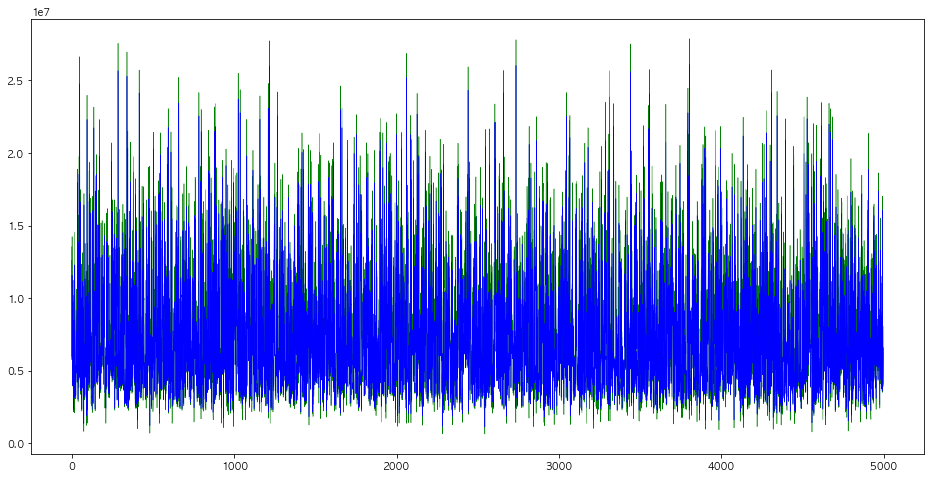

In [510]:
plt.figure(figsize=(16,8))

plt.plot(_report['공용부 청구서'], linewidth=0.5, color='g')
plt.plot(_report['누진단계 공동설비사용요금 예측'], linewidth=0.5, color='b')

plt.show()

percentage 오차 < 90% 비율 32%
percentage 오차 < 100% 비율 68%
percentage 오차 < 110% 비율 90%
percentage 오차 < 125% 비율 94%
percentage 오차 < 1.5% 비율 99%

예측치와 평균 오차 : 97%


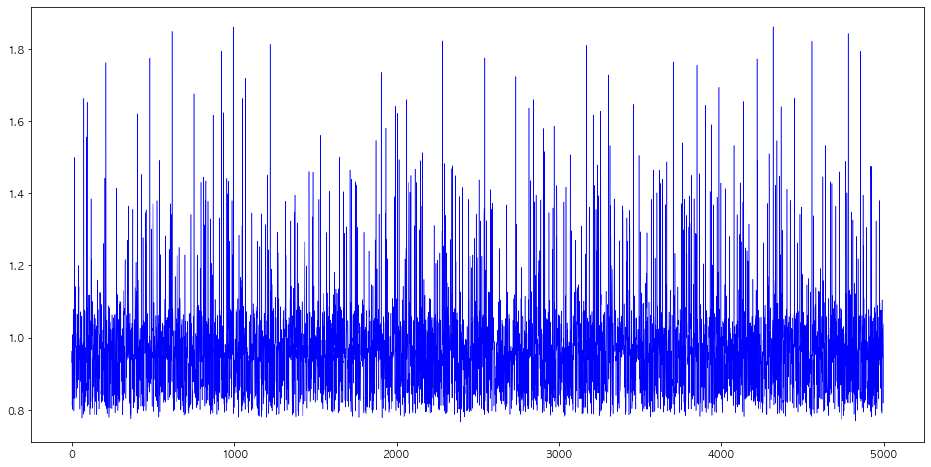

In [511]:
print("percentage 오차 < 90% 비율 {}%".format(round(len(
    households_info[households_info['percentage'] < 0.9]
) / test_cnt * 100)))

print("percentage 오차 < 100% 비율 {}%".format(round(len(
    households_info[households_info['percentage'] < 1]
) / test_cnt * 100)))

print("percentage 오차 < 110% 비율 {}%".format(round(len(
    households_info[households_info['percentage'] < 1.1]
) / test_cnt * 100)))

print("percentage 오차 < 125% 비율 {}%".format(round(len(
    households_info[households_info['percentage'] < 1.25]
) / test_cnt * 100)))

print("percentage 오차 < 1.5% 비율 {}%".format(round(len(
    households_info[households_info['percentage'] < 1.5]
) / test_cnt * 100)))

print()

print("예측치와 평균 오차 : {}%".format(
    round(
        households_info['percentage'].mean() * 100
    )
))

plt.figure(figsize=(16, 8))

plt.plot(households_info['percentage'], linewidth=0.5, color='b')

plt.show()

<AxesSubplot:>

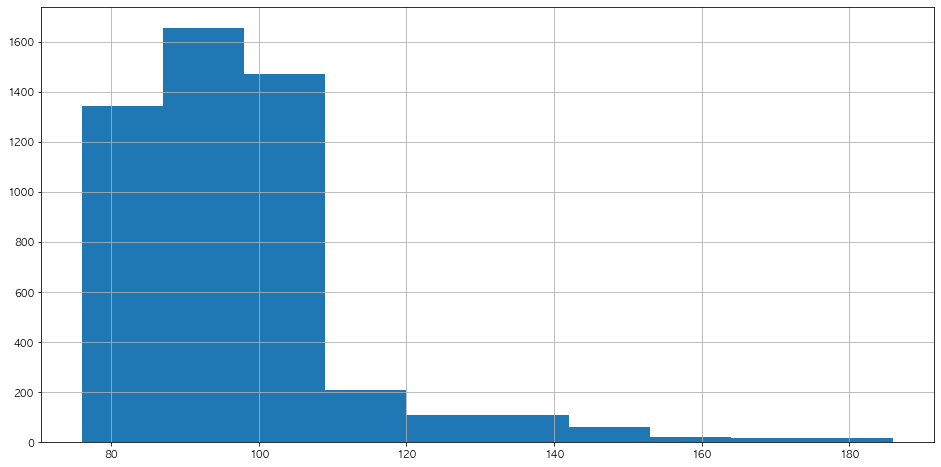

In [512]:
(households_info['percentage'] * 100).astype("int").hist(figsize=(16,8))